In [1]:
import sys
import numpy as np
import pandas as pd
import warnings
from utils import *

import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

%reload_ext autoreload
%autoreload 2
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
path = Path('../best-artworks-dataset/images/images')

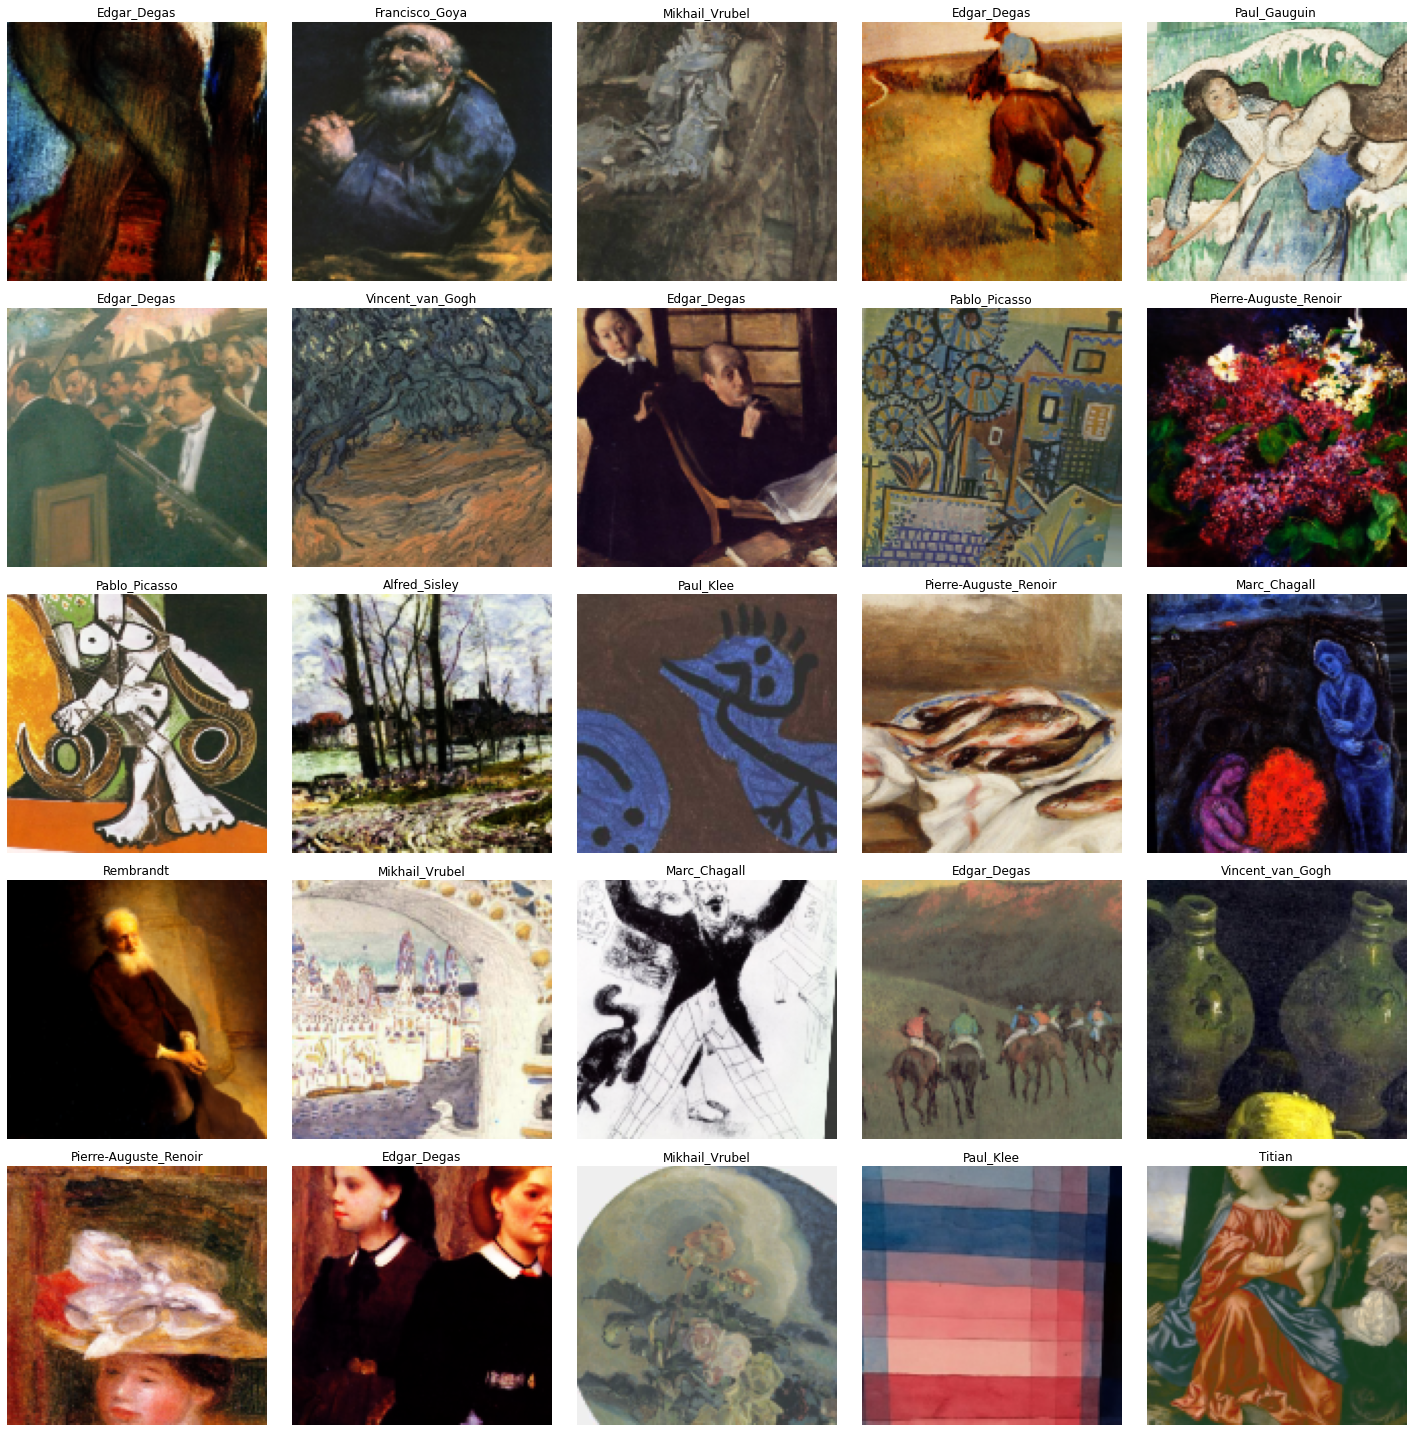

In [3]:
tfms = get_transforms(max_rotate= 10.,max_zoom=1., max_lighting=0.20, do_flip=False, max_warp=0., xtra_tfms=[flip_lr(), brightness(change=(0.3, 0.60), p=0.7), contrast(scale=(0.5, 2), 
                      p=0.7), crop_pad(size=600, padding_mode='border', row_pct=0.,col_pct=0.), rand_zoom(scale=(1.,1.5)), rand_crop(), perspective_warp(magnitude=(-0.1,0.1)),
                      symmetric_warp(magnitude=(-0.1,0.1))])
src = (ImageList.from_folder(path).split_by_rand_pct(0.2, seed=42).label_from_folder())

data = (src.transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=128).databunch(bs=64, num_workers=0).normalize(imagenet_stats))
data.show_batch()

In [4]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, model_dir="/temp/model" ).mixup()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\tda_m/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 6.92E-03


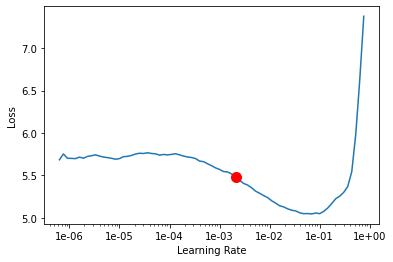

In [5]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [6]:
lr=1e-3
learn.fit_one_cycle(2, max_lr=slice(1e-2), wd = (1e-6, 1e-4, 1e-2), pct_start=0.5)
# DONE

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.20E-06


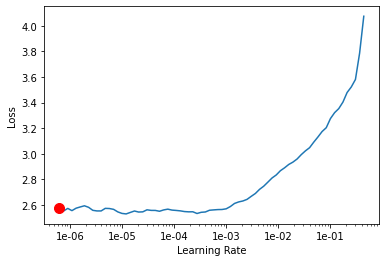

In [7]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [8]:
learn.fit_one_cycle(2, max_lr = slice(5e-6,lr/5), wd=(1e-6, 1e-4, 1e-2), pct_start=0.5)

In [9]:
data_big = (src.transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border', size=256)
        .databunch(bs=64, num_workers=0)
        .normalize(imagenet_stats))

learn.data = data_big

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 1.10E-05


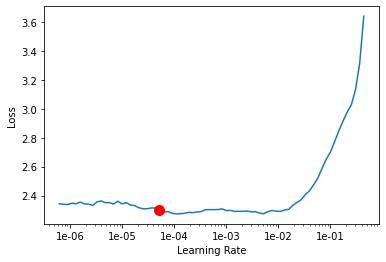

In [10]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [11]:
lr = 1e-5
learn.fit_one_cycle(2, max_lr=slice(lr), wd=(1e-6, 1e-4, 1e-2), pct_start=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


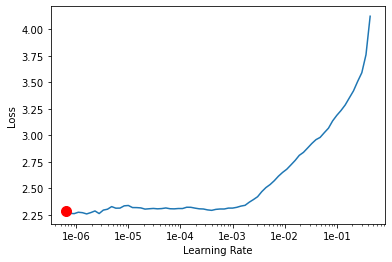

In [12]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [13]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4), wd=(1e-6, 1e-4, 1e-2), pct_start=0.5)

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data_big.valid_ds)==len(losses)==len(idxs)

True

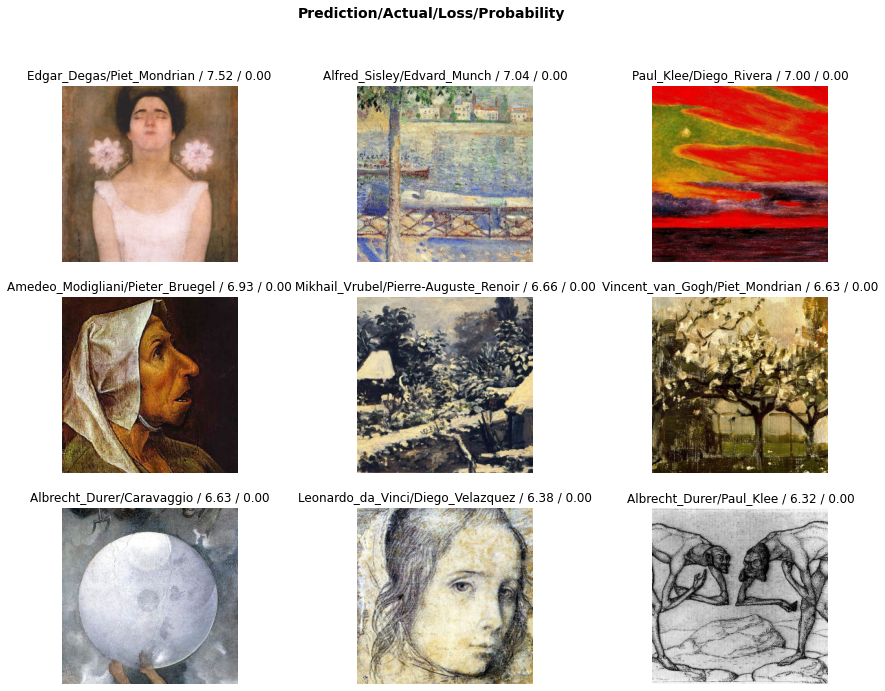

In [15]:
interp.plot_top_losses(9, figsize=(15,11))

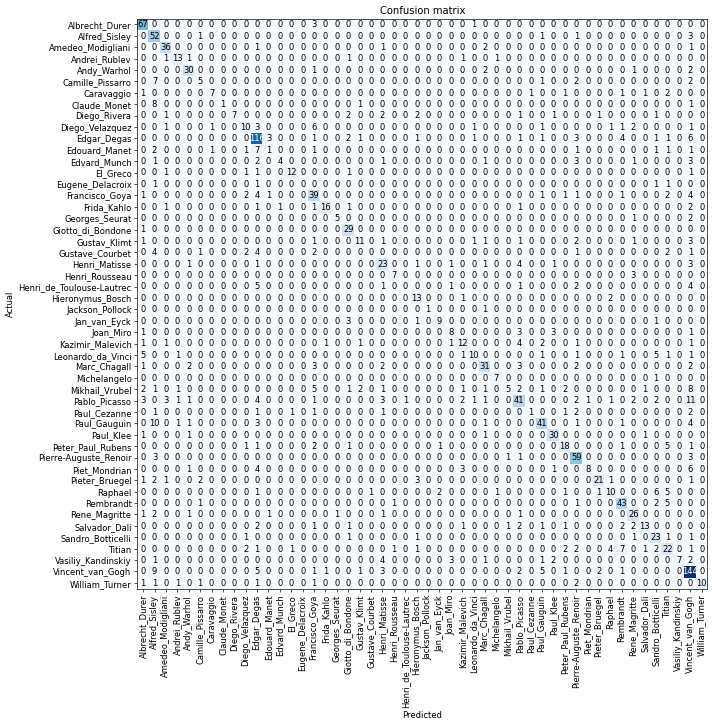

In [16]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [17]:
interp.most_confused(min_val=2)

[('Pablo_Picasso', 'Vincent_van_Gogh', 11),
 ('Paul_Gauguin', 'Alfred_Sisley', 10),
 ('Vincent_van_Gogh', 'Alfred_Sisley', 9),
 ('Claude_Monet', 'Alfred_Sisley', 8),
 ('Mikhail_Vrubel', 'Vincent_van_Gogh', 8),
 ('Camille_Pissarro', 'Alfred_Sisley', 7),
 ('Edouard_Manet', 'Edgar_Degas', 7),
 ('Titian', 'Rembrandt', 7),
 ('Diego_Velazquez', 'Francisco_Goya', 6),
 ('Edgar_Degas', 'Vincent_van_Gogh', 6),
 ('Piet_Mondrian', 'Vincent_van_Gogh', 6),
 ('Raphael', 'Sandro_Botticelli', 6),
 ('Henri_de_Toulouse-Lautrec', 'Edgar_Degas', 5),
 ('Leonardo_da_Vinci', 'Albrecht_Durer', 5),
 ('Leonardo_da_Vinci', 'Sandro_Botticelli', 5),
 ('Mikhail_Vrubel', 'Francisco_Goya', 5),
 ('Peter_Paul_Rubens', 'Titian', 5),
 ('Raphael', 'Titian', 5),
 ('Rembrandt', 'Titian', 5),
 ('Vincent_van_Gogh', 'Edgar_Degas', 5),
 ('Vincent_van_Gogh', 'Paul_Gauguin', 5),
 ('Edgar_Degas', 'Rembrandt', 4),
 ('Francisco_Goya', 'Edgar_Degas', 4),
 ('Francisco_Goya', 'Vincent_van_Gogh', 4),
 ('Gustave_Courbet', 'Alfred_Sisley',

In [18]:
learn.save('final_model')

In [19]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256